# Nenana Ice Classic - Decision Trees Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mlxtend.plotting import plot_decision_regions

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OneHotEncoder
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

# import datetime # didn't need after all

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

rng = np.random.RandomState(42)

## Helper Functions

In [2]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
#         self.ohe.fit(self.forest.apply(X)[:,:,0])
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
#         return self.ohe.transform(self.forest.apply(X)[:,:,0])
        return self.ohe.transform(self.forest.apply(X))


In [3]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [4]:
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

In [5]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
train = pd.read_csv('../data/model_training_data.csv')

In [7]:
train.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,precipIntensity,winningTime,daylightHours,iceThickness,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-10,0.14,0.31,9.60,78.0,1.0,0.0,0,0.465278,37.5,...,-7.142857e-01,1.303840e+00,4.857143,0.892857,-0.297619,1.951800,3.5,0.890909,-4.143851e-16,2.718251
1,1989-03-11,0.17,0.36,9.35,71.0,0.0,0.0,0,0.470139,37.5,...,-1.071429e+00,8.944272e-01,5.571429,0.714286,-0.595238,1.618347,4.2,0.848485,-2.651515e-01,2.616189
2,1989-03-12,0.21,0.41,6.70,59.0,1.0,0.0,0,0.475000,37.5,...,-7.142857e-01,4.472136e-01,6.142857,0.500000,-0.714286,1.214986,4.9,0.721212,-3.977273e-01,2.282786
3,1989-03-13,0.24,0.43,2.53,109.0,1.0,0.0,0,0.479167,37.5,...,3.332111e-15,2.471078e-08,6.571429,0.285714,-0.595238,0.786796,5.5,0.575758,-4.734848e-01,1.900292
4,1989-03-14,0.28,0.57,2.16,295.0,1.0,0.0,0,0.484028,37.5,...,3.332111e-15,2.471078e-08,6.857143,0.107143,-0.297619,0.377964,6.0,0.424242,-4.734848e-01,1.490712


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 1.5+ MB


In [9]:
test = pd.read_csv('../data/model_testing_data.csv')

In [10]:
test.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,precipIntensity,winningTime,daylightHours,iceThickness,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,2015-03-10,0.67,0.62,0.79,136.0,1.0,0.0,0,0.463889,38.5,...,7.142857e-01,1.303840,1.857143,0.500000,7.142857e-01,1.214986,1.6,0.278788,0.397727,1.074968
1,2015-03-11,0.70,0.61,0.77,317.0,1.0,0.0,0,0.468750,38.5,...,5.880195e-16,1.581139,2.428571,0.714286,5.952381e-01,1.618347,2.0,0.424242,0.473485,1.490712
2,2015-03-12,0.73,0.61,1.45,307.0,1.0,0.0,0,0.472917,38.5,...,1.176039e-15,1.581139,3.142857,0.892857,2.976190e-01,1.951800,2.5,0.575758,0.473485,1.900292
3,2015-03-13,0.77,0.57,1.36,257.0,1.0,0.0,0,0.477778,38.5,...,1.764059e-15,1.581139,4.000000,1.000000,-3.853551e-16,2.160247,3.1,0.721212,0.397727,2.282786
4,2015-03-14,0.80,0.60,0.66,128.0,1.0,0.0,0,0.482639,38.5,...,5.880195e-16,1.581139,5.000000,1.000000,7.707102e-17,2.160247,3.8,0.848485,0.265152,2.616189


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 295.0+ KB


## Modeling

#### Random Guess Accuracy = 0.9827072152653548

In [12]:
gc.collect()

11

In [13]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [14]:
used_cols = [c for c in train.columns if c not in exclude]

In [15]:
no_ma_cols = [c for c in train.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [16]:
pprint.pprint(no_ma_cols)
pprint.pprint(used_no_ma_cols)

['Date',
 'moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'winningTime',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'winningDate',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']
['moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']


In [17]:
train.dropna(inplace = True)

In [18]:
test.dropna(inplace = True)

In [19]:
gc.collect()

0

In [20]:
target = 'winningDate'

---
### Decision Tree Model Excluding Moving Average Features

In [21]:
dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=4,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

X_train, y_train = train[used_no_ma_cols], train[target]

scores = cross_validate(dt, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# f1: 0.19096654680178707 +/- 0.04114568615191551
# f1_weighted: 0.9445674227004865 +/- 0.008080880980218903
# precision: 0.1265204678362573 +/- 0.018560135856217897
# precision_weighted: 0.9686489684382966 +/- 0.006881514681462991
# recall: 0.44000000000000006 +/- 0.19849433241279207
# recall_weighted: 0.9258883248730964 +/- 0.016557874548527998
# accuracy: 0.9258883248730964 +/- 0.016557874548527998
# roc_auc: 0.6910924006908463 +/- 0.09247258191476308

f1: 0.19096654680178707 +/- 0.04114568615191551
f1_weighted: 0.9445674227004865 +/- 0.008080880980218903
precision: 0.1265204678362573 +/- 0.018560135856217897
precision_weighted: 0.9686489684382966 +/- 0.006881514681462991
recall: 0.44000000000000006 +/- 0.19849433241279207
recall_weighted: 0.9258883248730964 +/- 0.016557874548527998
accuracy: 0.9258883248730964 +/- 0.016557874548527998
roc_auc: 0.6910924006908463 +/- 0.09247258191476308


In [22]:
dt.fit(X_train, y_train)
X_test = test[used_no_ma_cols]
y_test = test[target]
y_pred = dt.predict(X_test)

In [23]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9055793991416309
Test set balanced_accuracy: 0.5605263157894737


lorem ipsum

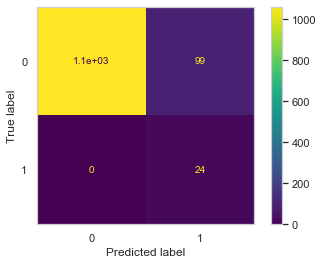

In [24]:
metrics.plot_confusion_matrix(dt, X_train, y_train);

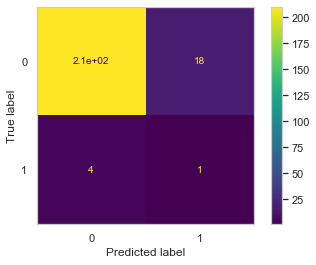

In [25]:
metrics.plot_confusion_matrix(dt, X_test, y_test);

lorem ipsum

In [26]:
y_pred_prob = dt.predict_proba(X_test)[:,1]
y_pred_prob[:5]

array([0., 0., 0., 0., 0.])

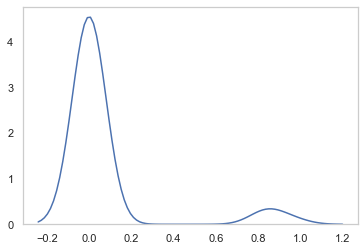

In [27]:
sns.kdeplot(y_pred_prob);

In [28]:
metrics.confusion_matrix(y_test, y_pred_prob > 0)

array([[210,  18],
       [  4,   1]])

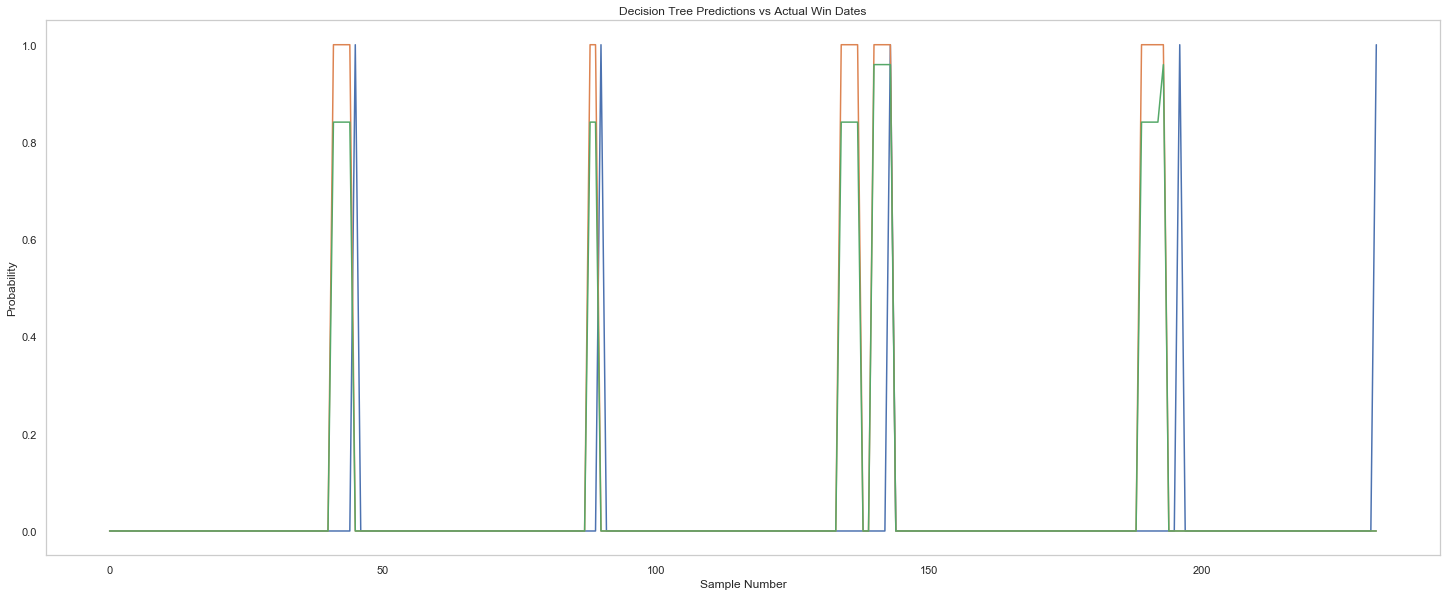

In [29]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.plot(y_pred_prob)
plt.tight_layout()
plt.title('Decision Tree Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Decision Tree Including Moving Average Features

In [30]:
dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=4,
                            min_samples_leaf=5,
                            random_state=42,
                            class_weight='balanced')

X_train, y_train = train[used_cols], train[target]

scores = cross_validate(dt, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# f1: 0.22939068100358423 +/- 0.028251368069403936
# f1_weighted: 0.9390852534533538 +/- 0.016124144791608896
# precision: 0.15162962962962961 +/- 0.027713357399031878
# precision_weighted: 0.9733964417793496 +/- 0.0048817174710536594
# recall: 0.61 +/- 0.2615339366124404
# recall_weighted: 0.9147208121827409 +/- 0.028965162675506816
# accuracy: 0.9147208121827409 +/- 0.028965162675506816
# roc_auc: 0.7655650906735751 +/- 0.11409189218238967

f1: 0.22939068100358423 +/- 0.028251368069403936
f1_weighted: 0.9390852534533538 +/- 0.016124144791608896
precision: 0.15162962962962961 +/- 0.027713357399031878
precision_weighted: 0.9733964417793496 +/- 0.0048817174710536594
recall: 0.61 +/- 0.2615339366124404
recall_weighted: 0.9147208121827409 +/- 0.028965162675506816
accuracy: 0.9147208121827409 +/- 0.028965162675506816
roc_auc: 0.7655650906735751 +/- 0.11409189218238967


In [31]:
dt.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = dt.predict(X_test)

In [32]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9227467811158798
Test set balanced_accuracy: 0.7649122807017543


Test set accuracy increased, indicating this is a better model.

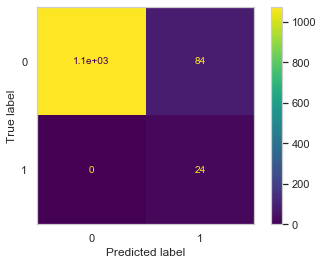

In [33]:
metrics.plot_confusion_matrix(dt, X_train, y_train);

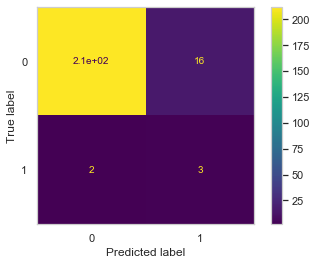

In [34]:
metrics.plot_confusion_matrix(dt, X_test, y_test);

This model successfully predicted 3 of 5 winning days in the test set.

In [35]:
y_pred_prob = dt.predict_proba(X_test)[:,1]
y_pred_prob[:5]

array([0., 0., 0., 0., 0.])

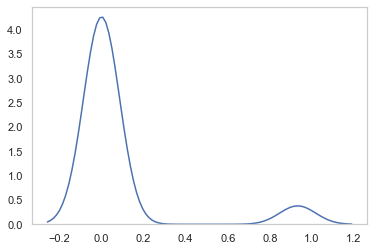

In [36]:
sns.kdeplot(y_pred_prob);

In [37]:
metrics.confusion_matrix(y_test, y_pred_prob > 0)

array([[212,  16],
       [  2,   3]])

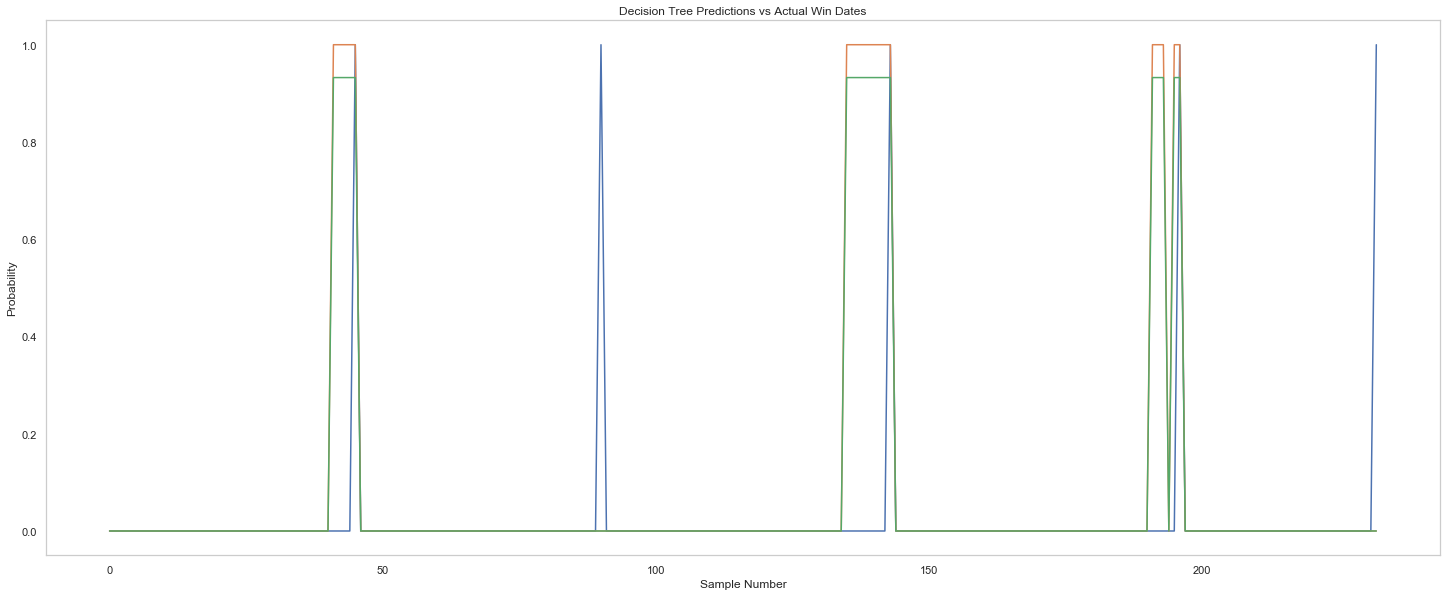

In [38]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.plot(y_pred_prob)
plt.tight_layout()
plt.title('Decision Tree Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
### Random Forest Model Excluding Moving Average Features

#### Grid search to find best parameters

In [39]:
# rf = RandomForestClassifier(random_state = 42)

In [40]:
# grid_p = {"n_estimators": [20, 50, 100], # first run
# # grid_p = {"n_estimators": [40, 50, 60], # second run
# grid_p = {"n_estimators": [50, 60, 70], # third run
#           "criterion": ["gini", "entropy"],
#           "max_features": ['sqrt', 'log2', 0.2],
# #           "max_depth": [4, 6, 10], # first run
# #           "max_depth": [8, 10, 12], # second run
#           "max_depth": [7, 8, 9], # third run
# #           "min_samples_split": [2, 5, 10], # first run
#           "min_samples_split": [1, 2, 3], # second run
#           "min_samples_leaf": [1, 5, 10]}

# grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=TimeSeriesSplit(), scoring='roc_auc')
# grid_search.fit(X_train, y_train)

In [41]:
# grid_search.best_score_
# first run best = 0.9738471502590673
# second run best = 0.9756606217616579

In [42]:
# grid_search.best_params_
# first run
# {'criterion': 'entropy',
#  'max_depth': 10,
#  'max_features': 0.2,
#  'min_samples_leaf': 5,
#  'min_samples_split': 2,
#  'n_estimators': 50}

# second run
# {'criterion': 'entropy',
#  'max_depth': 8,
#  'max_features': 0.2,
#  'min_samples_leaf': 5,
#  'min_samples_split': 2,
#  'n_estimators': 60}

In [43]:
# best_rf = grid_search.best_estimator_

# y_pred = best_rf.predict_proba(X_test)[:,1]
# metrics.roc_auc_score(y_test, y_pred)
# first run best = 0.9631578947368421
# second run best = 0.9675438596491228

In [44]:
# n_trees = best_rf.get_params()['n_estimators']

# scores = cross_val_score(best_rf, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc') 
# print(scores.mean(), "+/-", scores.std())
# first run: 0.9738471502590673 +/- 0.0075067421171112255
# second run: 0.9756606217616579 +/- 0.00944409789195802

In [45]:
# encoder = ForestEncoder(best_rf)
# clf = LogisticRegressionCV(class_weight='balanced', random_state = 42, n_jobs = -1, scoring = 'recall')
# pipe = make_pipeline(encoder, clf)

# scores = cross_val_score(pipe, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc')
# print(scores.mean(), "+/-", scores.std())
# first run: 0.9714594127806564 +/- 0.010449050086355797
# second run: 0.9715155440414508 +/- 0.012251749750802725

#### Create model using grid search parameters

In [46]:
rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 7,
                            max_features = 0.2,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

encoder = ForestEncoder(rf)

clf = LogisticRegressionCV(scoring = 'recall',
                           cv = TimeSeriesSplit(),
                           class_weight = 'balanced',
                           n_jobs = -1,
                           random_state = 42)

pipe = make_pipeline(encoder, clf)

X_train, y_train = train[used_no_ma_cols], train[target]

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# all metrics report NaN

f1: nan +/- nan
f1_weighted: nan +/- nan
precision: nan +/- nan
precision_weighted: nan +/- nan
recall: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [47]:
pipe.fit(X_train, y_train)
X_test = test[used_no_ma_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [48]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9313304721030042
Test set balanced_accuracy: 0.8671052631578948


Another increase in test set accuracy.

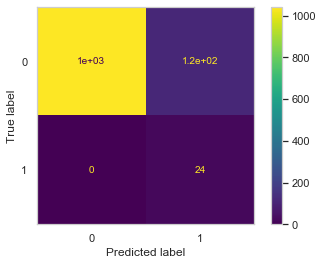

In [49]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

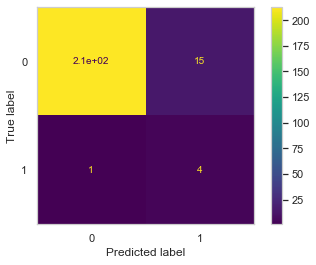

In [50]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

This model successfully predicts 4 of 5 winning dates in the test set.

In [51]:
y_pred_prob = pipe.predict_proba(X_test)[:,1]
y_pred_prob[:5]

array([0.12160848, 0.12462226, 0.12462226, 0.11528339, 0.11855496])

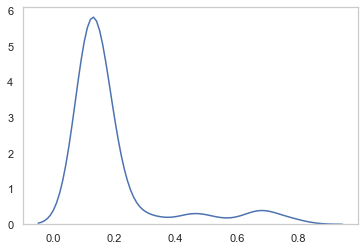

In [52]:
sns.kdeplot(y_pred_prob);

In [53]:
metrics.confusion_matrix(y_test, y_pred_prob > 0.356)

array([[205,  23],
       [  1,   4]])

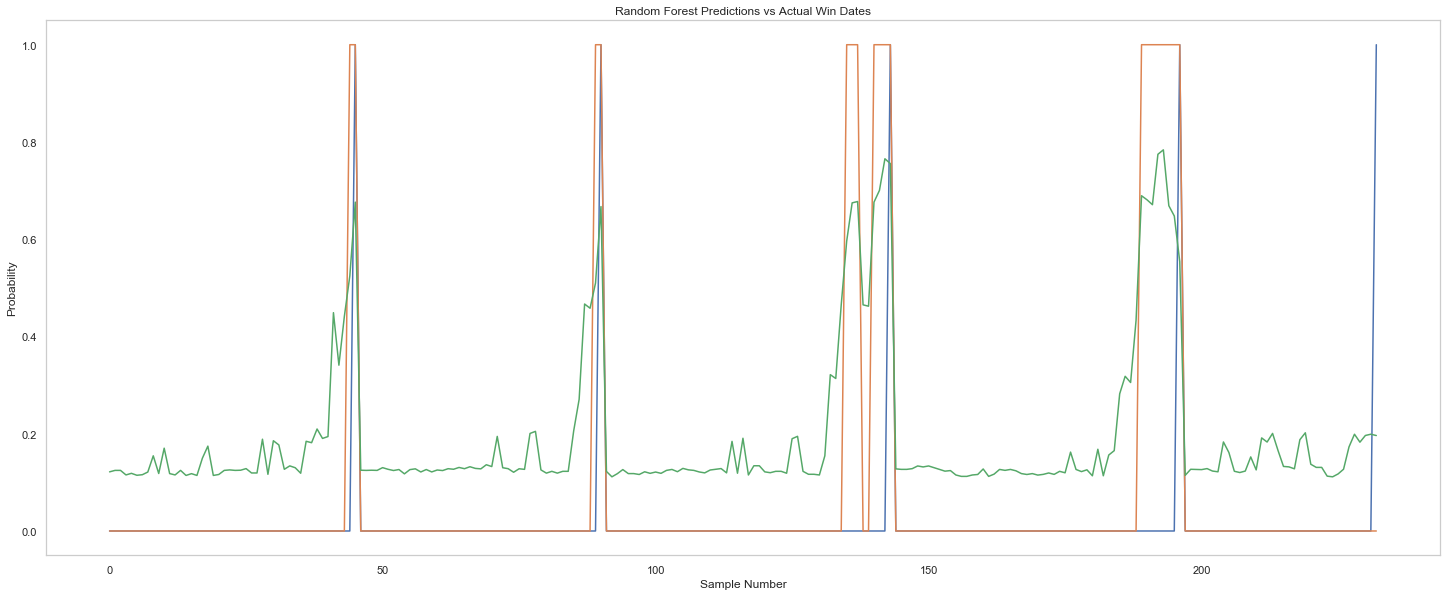

In [54]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.plot(y_pred_prob)
plt.tight_layout()
plt.title('Random Forest Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
### Random Forest Model Including Moving Average Features

#### Grid search to find best parameters

In [55]:
# rf = RandomForestClassifier(random_state = 42)

In [56]:
# # grid_p = {"n_estimators": [20, 50, 100], # first run
# # grid_p = {"n_estimators": [40, 50, 60], # second run
# grid_p = {"n_estimators": [50, 60, 70], # third run
#           "criterion": ["gini", "entropy"],
#           "max_features": ['sqrt', 'log2', 0.2],
# #           "max_depth": [4, 6, 10], # first run
# #           "max_depth": [6, 8, 10], # second run
#           "max_depth": [5, 6, 7], # third run
# #           "min_samples_split": [2, 5, 10], # first run
#           "min_samples_split": [1, 2, 3], # second run, third run
#           "min_samples_leaf": [1, 5, 10]}

# grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=TimeSeriesSplit(), scoring='roc_auc')
# grid_search.fit(X_train, y_train)

In [57]:
# grid_search.best_score_

In [58]:
# grid_search.best_params_

In [59]:
# best_rf = grid_search.best_estimator_

# y_pred = best_rf.predict_proba(X_test)[:,1]
# metrics.roc_auc_score(y_test, y_pred)

In [60]:
# n_trees = best_rf.get_params()['n_estimators']

# scores = cross_val_score(best_rf, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc') 
# print(scores.mean(), "+/-", scores.std())

In [61]:
# encoder = ForestEncoder(best_rf)
# clf = LogisticRegressionCV(class_weight='balanced', random_state = 42, n_jobs = -1, scoring = 'recall')
# pipe = make_pipeline(encoder, clf)

# scores = cross_val_score(pipe, X_train, y_train, cv=TimeSeriesSplit(), scoring='roc_auc')
# print(scores.mean(), "+/-", scores.std())

#### Create model using grid search parameters

In [62]:
# BEST OVERALL MODEL

rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 6,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

encoder = ForestEncoder(rf)

clf = LogisticRegressionCV(class_weight = 'balanced',
                           random_state = 42,
                           cv = TimeSeriesSplit(),
                           solver = 'liblinear',
                           n_jobs = -1,
                           scoring = 'recall')

pipe = make_pipeline(encoder, clf)

X_train, y_train = train[used_cols], train[target]

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# performance
# all metrics report NaN

f1: nan +/- nan
f1_weighted: nan +/- nan
precision: nan +/- nan
precision_weighted: nan +/- nan
recall: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [63]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [64]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9570815450643777
Test set balanced_accuracy: 0.8802631578947369


Test set accuracy increased again.

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

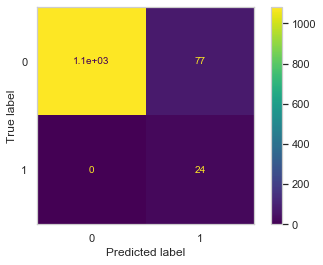

In [65]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

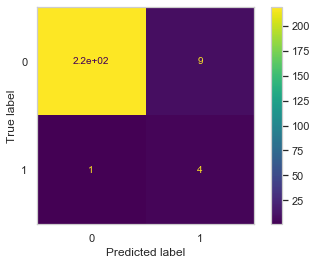

In [66]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

This model also correctly predicted 4 of 5 winning dates in the test set, and had fewer false positives. This is the best model so far.

In [67]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
y_pred_prob[:5]

array([0., 0., 0., 0., 0.])

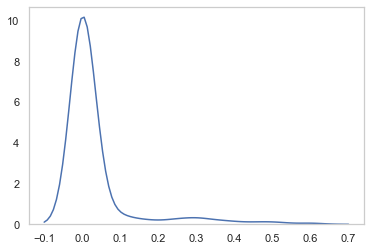

In [68]:
sns.kdeplot(y_pred_prob);

In [69]:
metrics.confusion_matrix(y_test, y_pred_prob > 0)

array([[175,  53],
       [  0,   5]])

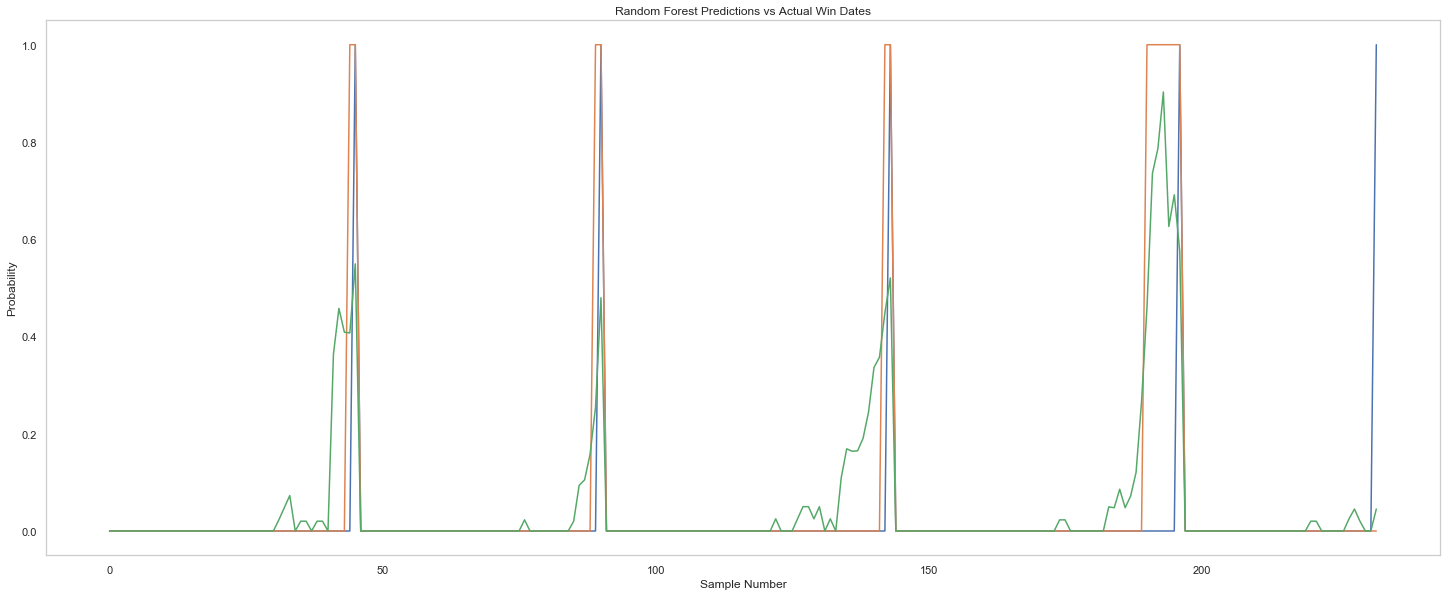

In [70]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.scatter(x = test['Date'], y = 1.5*y_pred_prob)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [ ]:
plt.

---
### Gradient Boosted Trees

#### Grid search to find best parameters

In [210]:
clf = HistGradientBoostingClassifier(random_state = 42, verbose = 1)

In [ ]:
grid_p = {"learning_rate" : [0.01, 0.1, 1], # first run
# grid_p = {"learning_rate" : [0.13, 0.15, 0.18], # second run
# grid_p = {"learning_rate" : [0.16, 0.18, 0.2], # third run
# grid_p = {"learning_rate" : [0.19, 0.2, 0.21], # fourth run
          "max_iter" : [100, 200, 500], # first run
#           "max_iter" : [75, 100, 125], # second run
#           "max_iter" : [60, 75, 90], # third run
#           "max_iter" : [68, 75, 83], # fourth run
#           "max_leaf_nodes" : [2**4-1, 2**5-1, 2**6-1], # first run
          "max_leaf_nodes" : [2**3-1, 2**4-1, 2**5-1], # second run, fourth run
#           "max_leaf_nodes" : [2**4-1], #third run
          "max_depth" : [6, 10, 20], # first run
#           "max_depth" : [8, 10, 12], # second run
#           "max_depth" : [7, 8, 9], # third run
#           "max_depth" : [6, 7, 8], # fourth run
          "min_samples_leaf" : [10, 20, 30], # first run
          "l2_regularization" : [0.1, 0.5, 0.9], # first run
#           "l2_regularization" : [0.85, 0.9, 0.95], # second run
#           "l2_regularization" : [0.87, 0.9, 0.93], # third run
#           "l2_regularization" : [0.86, 0.87, 0.88], # fourth run
          "max_bins" : [100, 150, 200], # first run
#           "max_bins" : [125, 150, 175], # second run
#           "max_bins" : [140, 150, 160], # third run
#           "max_bins" : [145, 150, 155], # fourth run
          "n_iter_no_change" : [50, 100, 250], # first run
          "tol" : [1e-06, 1e-07, 1e-08]} #first run


grid_search = GridSearchCV(clf, grid_p, n_jobs=-1, cv=TimeSeriesSplit(), scoring='accuracy')
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [201]:
X_train, y_train = train[used_cols], train[target]

clf = HistGradientBoostingClassifier(loss='auto',
                                     random_state=42,
                                     learning_rate=0.2,
                                     max_iter=83,
                                     max_leaf_nodes=2**4-1,
                                     max_depth = 6,
                                     max_bins=150,
                                     l2_regularization=0.88)

scores = cross_validate(clf, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548

# f1: 0.25575757575757574 +/- 0.21980540688580677
# f1_weighted: 0.9717186802484026 +/- 0.005628132897334418
# precision: 0.2523809523809524 +/- 0.2127457895589398
# precision_weighted: 0.9687815007347597 +/- 0.012148167939721965
# recall: 0.3 +/- 0.29154759474226505
# recall_weighted: 0.9756345177664976 +/- 0.003798636940887261
# accuracy: 0.9756345177664976 +/- 0.003798636940887261
# roc_auc: 0.9584925518134716 +/- 0.011562842263328236

f1: 0.2704761904761905 +/- 0.2530969179713995
f1_weighted: 0.9746044193066175 +/- 0.008950984021610995
precision: 0.4666666666666666 +/- 0.45215533220835125
precision_weighted: 0.9711912185442945 +/- 0.015010169921554892
recall: 0.2 +/- 0.18708286933869708
recall_weighted: 0.980710659898477 +/- 0.005919748116594182
accuracy: 0.980710659898477 +/- 0.005919748116594182
roc_auc: 0.9570876511226253 +/- 0.012220357495309088


In [202]:
clf.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = clf.predict(X_test)

In [203]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9785407725321889
Test set balanced_accuracy: 0.5


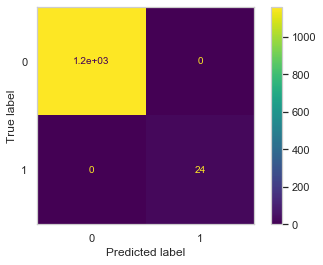

In [204]:
metrics.plot_confusion_matrix(clf, X_train, y_train);

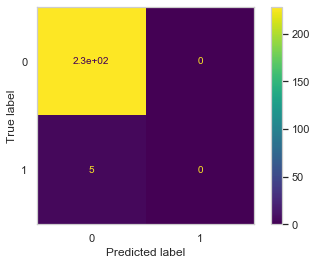

In [205]:
metrics.plot_confusion_matrix(clf, X_test, y_test);

In [206]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred_prob[:5]

array([4.67277688e-05, 8.33711917e-05, 3.85723420e-05, 3.33332003e-05,
       5.94453685e-05])

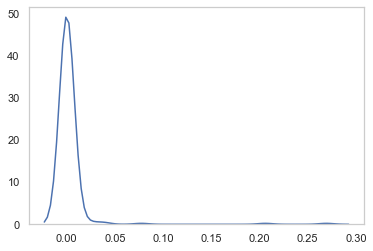

In [207]:
sns.kdeplot(y_pred_prob);

In [208]:
metrics.confusion_matrix(y_test, y_pred_prob > 0)

array([[  0, 228],
       [  0,   5]])

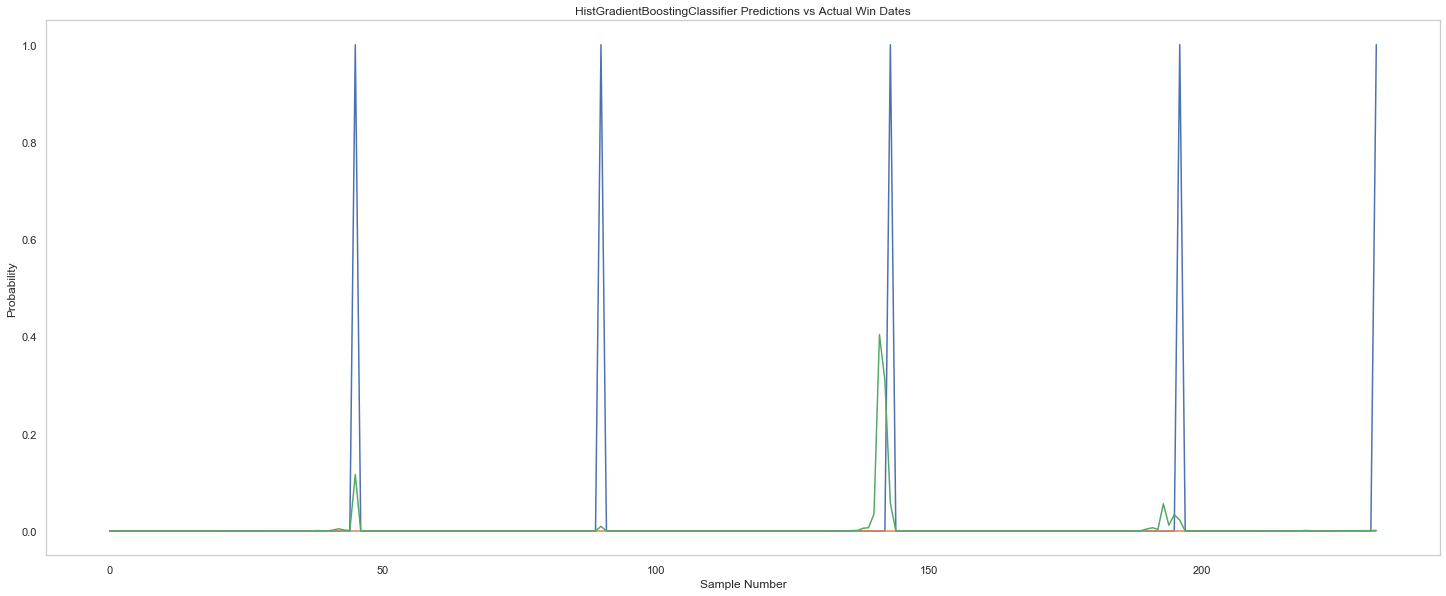

In [209]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.plot(1.5*y_pred_prob)
plt.tight_layout()
plt.title('HistGradientBoostingClassifier Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()